In [21]:
import scipy.io as sio
import numpy as np

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

mat_contents = sio.loadmat('4chanEMG.mat')
mat_data = mat_contents['signalArr']
mat_data = mat_data[:, :, 0:540]
print(mat_data.shape)
# print(mat_data[0])
mat_labels = mat_contents['signalLabel']
mat_labels -= 1

# ae = AutoEncoder(encoding_dim=135, input_data=mat_data, batch_size=32, epochs=300)
# ae.encoder_decoder()
# ae.fit()

train_data, test_data = train_test_split(mat_data, test_size=0.2, shuffle=True)
train_data = np.reshape(train_data, (len(train_data), 1, 4, 540))
test_data = np.reshape(test_data, (len(test_data), 1, 4, 540))
print("Train Data shape:", train_data.shape)

input_arr = Input(shape=(1, 4, 540))
batch_size = 32

# Encoder section
x = Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same', data_format='channels_first')(input_arr)
# x = BatchNormalization()(x) -> figure out how to add batch normalisation
# 64x2x270
x = MaxPooling2D((2, 2), padding='same', data_format='channels_first')(x)
x = Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same', data_format='channels_first')(x)
# x = BatchNormalization()(x) -> figure out how to add batch normalisation
# 32x1x135
encoded = MaxPooling2D((2, 2), padding='same', data_format='channels_first')(x)
# 1x1x135 -> ADD THIS BIT
print("Encoded shape:", encoded.shape)

# Decoder section
x = Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same', data_format='channels_first')(encoded)
# 32x2x270
x = UpSampling2D((2, 2), data_format='channels_first')(x)
x = Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same', data_format='channels_first')(x)
# 64x4x540
x = UpSampling2D((2, 2), data_format='channels_first')(x)
# 1x4x540
decoded = Conv2D(filters=1, kernel_size=(5, 5), activation='sigmoid', padding='same', data_format='channels_first')(x)

print("Decoded shape:", decoded.shape)

# Arguments are inputs and output
auto_encoder = Model(input_arr, decoded)
print(auto_encoder.summary())
auto_encoder.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['mse', 'accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=15)
ae = auto_encoder.fit(train_data, train_data,
                      epochs=10,
                      batch_size=batch_size,
                      validation_data=(test_data, test_data),
                      verbose=1,
                      callbacks=[early_stop])

print(ae.history.keys())
print("Model fitting complete")
# test_loss, test_acc = auto_encoder.evaluate(test_data, test_data)
# print("Test accuracy:", test_acc)

prediction = auto_encoder.predict(test_data)

(9180, 4, 540)
Train Data shape: (7344, 1, 4, 540)
Encoded shape: (?, 32, 1, 135)
Decoded shape: (?, 1, 4, 540)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 4, 540)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 4, 540)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 2, 270)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 2, 270)        8224      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 1, 135)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 1, 135)        4128      
______________________________

In [22]:
print(ae.history['val_acc'])

[0.042761035304118865, 0.042761035304118865, 0.045674977746988955, 0.04609255175347681, 0.0459455433250902, 0.045719105279588494, 0.04555520185620437, 0.045451312518652226, 0.045433409471462495, 0.04541021066845632]


(1836, 1, 4, 540)


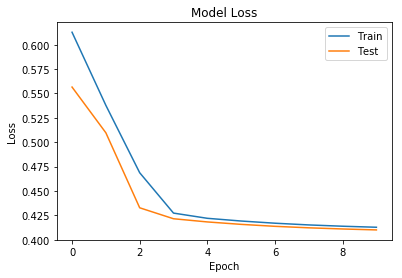

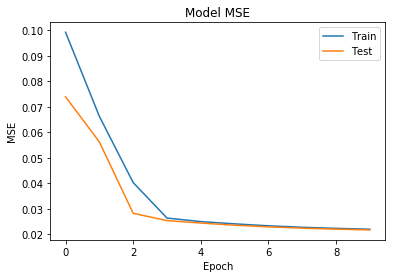

In [25]:
print(prediction.shape)

length = len(test_data)
mse = np.empty(shape=(length, 4))
for i in range(length):
    mse[i, :] = np.mean(np.power(test_data[i, 0, :, :] - prediction[i, 0, :, :], 2), axis=1)

np.savetxt("ae_mse.txt", mse)

plt.plot(ae.history['loss'])
plt.plot(ae.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(ae.history['mean_squared_error'])
plt.plot(ae.history['val_mean_squared_error'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Model MSE')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# f = open("ae_results.txt", "w+")
# f.write("Test accuracy: %d \r\n" % test_acc)
# f.write("Test loss: %d \r\n\n" % test_loss)
# f.close()
#
# np.savetxt("ae_test.txt", test_data[10, 0, :, :])
# np.savetxt("ae_predict.txt", prediction[10, 0, :, :])